In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms

In [2]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim*2)  # Outputs mean and log variance
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Ensure output range [0, 1] if input is normalized
        )
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        flat_x = x.view(x.size(0), -1)  # Flatten the image
        params = self.encoder(flat_x)
        mu, log_var = params[:, :latent_dim], params[:, latent_dim:]
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decoder(z)
        return reconstruction, mu, log_var

def vae_loss(recon_x, x, mu, log_var):
    x_flat = x.view(x.size(0), -1)
    recon_loss = nn.functional.mse_loss(recon_x, x_flat, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_div

def train_vae(model, data_loader, optimizer, epochs=150, device=torch.device('cpu')):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, _ in data_loader:
            data = data.to(device)
            optimizer.zero_grad()
            reconstruction, mu, log_var = model(data)
            loss = vae_loss(reconstruction, data, mu, log_var)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(data_loader.dataset)}')


In [3]:
input_dim = 3 * 32 * 32  
latent_dim = 50
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")a

model = VAE(input_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from dataloader import get_dataloader_vae
train_loader, _ = get_dataloader_vae('cifar10', batch_size=128)

train_vae(model, train_loader, optimizer, epochs=150, device=device)

Files already downloaded and verified
Epoch 1, Loss: 2233.728536875
Epoch 2, Loss: 2018.456378125
Epoch 3, Loss: 1977.65672125
Epoch 4, Loss: 1959.8015621875
Epoch 5, Loss: 1948.9363915625
Epoch 6, Loss: 1943.0913384375
Epoch 7, Loss: 1939.862175625
Epoch 8, Loss: 1936.414308125
Epoch 9, Loss: 1935.14116875
Epoch 10, Loss: 1932.475371875
Epoch 11, Loss: 1931.74374375
Epoch 12, Loss: 1930.0099728125
Epoch 13, Loss: 1929.1021465625
Epoch 14, Loss: 1928.122351875
Epoch 15, Loss: 1927.0648165625
Epoch 16, Loss: 1926.513241875
Epoch 17, Loss: 1925.4774084375
Epoch 18, Loss: 1924.7321553125
Epoch 19, Loss: 1923.794861875
Epoch 20, Loss: 1923.7930209375
Epoch 21, Loss: 1922.8531846875
Epoch 22, Loss: 1922.1847275
Epoch 23, Loss: 1921.730876875
Epoch 24, Loss: 1921.323214375
Epoch 25, Loss: 1921.071755
Epoch 26, Loss: 1920.7391671875
Epoch 27, Loss: 1920.0458484375
Epoch 28, Loss: 1919.5412025
Epoch 29, Loss: 1919.443245625
Epoch 30, Loss: 1918.6580521875
Epoch 31, Loss: 1918.8665975
Epoch 32,

Files already downloaded and verified
Class 0: AUROC: 0.50, AUPR: 0.10, TPR at FPR 95%: 0.0, with Threshold: 1.4695383310317993
Class 1: AUROC: 0.49, AUPR: 0.10, TPR at FPR 95%: 0.0, with Threshold: 1.4810532331466675
Class 2: AUROC: 0.50, AUPR: 0.10, TPR at FPR 95%: 0.0, with Threshold: 1.4773341417312622
Class 3: AUROC: 0.49, AUPR: 0.10, TPR at FPR 95%: 0.0, with Threshold: 1.479519248008728
Class 4: AUROC: 0.50, AUPR: 0.10, TPR at FPR 95%: 0.0, with Threshold: 1.4774266481399536
Class 5: AUROC: 0.50, AUPR: 0.10, TPR at FPR 95%: 0.0, with Threshold: 1.4793035984039307
Class 6: AUROC: 0.50, AUPR: 0.10, TPR at FPR 95%: 0.0, with Threshold: 1.4771168231964111
Class 7: AUROC: 0.50, AUPR: 0.10, TPR at FPR 95%: 0.0, with Threshold: 1.4775034189224243
Class 8: AUROC: 0.50, AUPR: 0.10, TPR at FPR 95%: 0.0, with Threshold: 1.477062702178955
Class 9: AUROC: 0.50, AUPR: 0.10, TPR at FPR 95%: 0.0, with Threshold: 1.4836418628692627


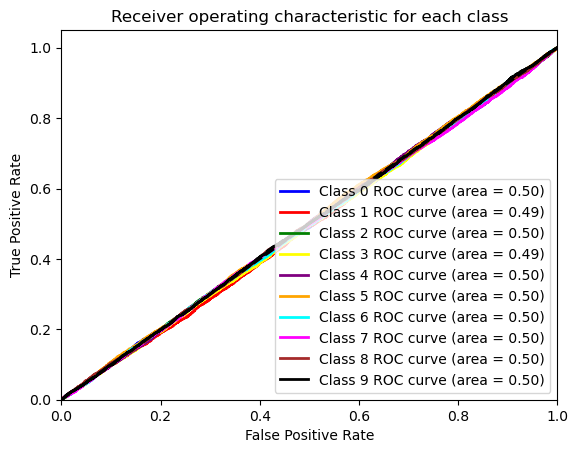

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from models import VAE
from dataloader import get_dataloader_vae
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_size = 100
model = VAE(latent_size).to(device)
data_loader, _ = get_dataloader_vae('cifar10', batch_size=128)

class Metrics:
    def __init__(self, model, data_loader, device):
        self.model = model.to(device)
        self.data_loader = data_loader
        self.device = device

    def evaluate(self):
        self.model.eval()
        labels, scores = [], []
        with torch.no_grad():
            for data, target in self.data_loader:
                data = data.to(self.device)
                outputs, _, _, _ = self.model(data)
                outputs = outputs.view(outputs.shape[0], -1)
                scores.append(outputs.cpu().numpy())
                labels.append(target.cpu().numpy())
        labels = np.concatenate(labels)
        scores = np.concatenate(scores, axis=0)
        return labels, scores

    def plot_roc_curves(self):
        labels, scores = self.evaluate()
        classes = np.unique(labels)
        y_bin = label_binarize(labels, classes=classes)

        # Compute ROC curve and ROC area for each class
        metrics_dict = {}
        for i, class_ in enumerate(classes):
            current_scores = scores[:, i]
            fpr, tpr, thresholds = roc_curve(y_bin[:, i], current_scores)
            roc_auc = auc(fpr, tpr)
            precision, recall, pr_thresholds = precision_recall_curve(y_bin[:, i], current_scores)
            pr_auc = average_precision_score(y_bin[:, i], current_scores)
            idx = np.min(np.where(fpr <= 0.95)) if np.any(fpr <= 0.95) else -1
            metrics_dict[class_] = {
                "AUROC": roc_auc,
                "AUPR": pr_auc,
                "TPR_at_FPR95": tpr[idx] if idx != -1 else None,
                "Threshold_at_FPR95": thresholds[idx] if idx != -1 else None
            }

        # Print each class's metrics
        for key, value in metrics_dict.items():
            print(f"Class {key}: AUROC: {value['AUROC']:.2f}, AUPR: {value['AUPR']:.2f}, "
                  f"TPR at FPR 95%: {value['TPR_at_FPR95']}, with Threshold: {value['Threshold_at_FPR95']}")

        # Plot all ROC curves
        plt.figure()
        colors = iter(['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'black'])
        for i, class_ in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_bin[:, i], scores[:, i])
            plt.plot(fpr, tpr, color=next(colors), lw=2, label=f'Class {class_} ROC curve (area = {metrics_dict[class_]["AUROC"]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for each class')
        plt.legend(loc="lower right")
        plt.show()

metrics = Metrics(model, data_loader, device)
metrics.plot_roc_curves()
